# Bayesian Statistics Using Sampling Methods

This workbook adds more detail on the theoretical underpinnings of Metropolis Hastings MCMC and slightly tweaks and expounds on some examples from Thomas Wiecki's excellent [blogpost on this topic](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).  Of course, all errors are mine.  

In order to understand our parameters $\theta$, MH MCMC trys to sample from our parameters' distribution, which is unknown.  This distribution is the posterior, or $Pr(\theta|y)$.  If we can somehow construct this distribution we can extract information about $\theta$.  

To see this, consider the following trivial example.  Suppose we have one parameter and are somehow able to construct the posterior distribution.  For simplicity, suppose the posterior is distributed $N(0,1)$ (the standard normal distribution).  If we take draws from this distribution, we can learn alot about its shape:

In [4]:
%matplotlib inline
import numpy as np
from scipy.stats import norm,uniform,lognorm
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore')

sbn.set_style('white')
sbn.set_context('talk')

In [5]:
# define the posterior distribution
def posterior(mean,std,N):
    return norm.rvs(mean,std,N)

The mean of theta is  0.002552528159105638
The standard deviation of theta is  1.0027777454917184
95% CI of theta is  [-1.95823558  1.97137704]


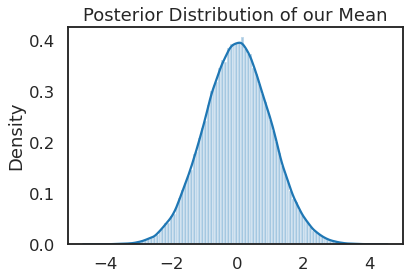

In [6]:
# take a random sample from the posterior:
sample = posterior(0,1,100000)

# calculate mean:
print("The mean of theta is ",np.mean(sample))
print("The standard deviation of theta is ", np.std(sample))
print("95% CI of theta is ", np.percentile(sample,[2.5,97.5]))

# plot histogram
plt.title('Posterior Distribution of our Mean')
sbn.distplot(sample,bins=100)
plt.show()

Note, our sample values from the standard normal are exactly as one would expect and we hardly needed to sample from this posterior to know about $\theta$.  For more interesting problems, we won't be able to construct (or know the properties of) the posterior as easily, so we need to devise a way to sample from the posterior to uncover information about $\theta$.  This is exactly what the Metropolis Hastings Algorithm does.

## The Metropolis-Hastings Random Walk Algorithm

The Metropolis-Hastings algorithm is simply a random number generator from our posterior distribution.

>The **Metroplis-Hastings algorithm** has been named one of the top 10 algorithms of the 20th century and appears on both the Math and Computational Sciences lists.

Consider constructing a set or series of potential beta vectors that explore the posterior distribution described above.  When selecting beta vectors we would like to explore parameters having higher probability for the posterior ($Prob(\theta|\mathbf{X},\mathbf{Y},\alpha)$) . Essentially we want to construct a series of random draws from the posterior pdf of our parameters (called a chain) that is in regions of the parameter space that are high probability for the posterior.  Once the chain is constructed, it reflects the underlying distribution of our parameter estimates.  

### Step 1. Generate proposal

We need to add **another** pdf to the mix: the **proposal distribution**.  The proposal distribution is an exogenously assigned distribution from which we draw proposed values of our parameter vector $\theta$.  Suppose we choose a symmetric proposal distribution such that $Prob(\theta_{t+1}|\theta_t) = Prob(\theta_t|\theta_{t+1})$.  For example, we might specify that $\theta_{t+1} = \theta_t + N(0,\omega)$, where $N(0,\omega)$ is a random normal variate mean 0 standard deviation $\omega$.  Both of the differences $(\theta_{t+1} - \theta_t)$ and $(\theta_{t+1} - \theta_t)$  are distributed normal with mean 0 and standard deviation $\omega$, so we say the proposal distribution is symmetric.  Given our symmetric proposal distribution, denote the probability of $\theta^P_{t+1}$ conditional on $\theta_{t}$ as $Prob(\theta^P_{t+1}|\theta_t) = q(\theta^P_{t+1}|\theta_{t})$  Using a proposal distribution of this form leads to the __random walk Metropolis-Hastings algorithm__, the most common variety of MH in use.  

Denote, $\theta_t$ as the current value of our Markov Chain and $\theta^P_{t+1}$ as the proposed value.  Metropolis-Hastings lets us define an accept/reject criteria, where accept means that the candidate draw ($\theta_{t+1}$) provides information about $\theta$ in high probability regions, and is therefore a suitable draw from the posterior distribution of $\theta$. 

> The parameter $\omega$, the standard deviation of the random walk error term is often referred to as the **sample width** or **proposal width** parameter and we will turn back to this later in this notebook.

### Step 2. Incorporate Bayes Rule

Recall that we can write Bayes Rule for our model as
$$
Prob(\theta |\mathbf{y}) = \frac{Prob(\mathbf{y}|\theta,\mathbf{x})Prob(\theta|\mathbf{x}))}{Prob(\mathbf{y}|\mathbf{x})}
$$
Using Bayes Rule, we can evaluate how likely our proposed value ($\theta^P_{t+1}$) is relative to the current value in our chain ($\theta_{t+1}$):

$$
\frac{Prob(\theta^P_{t+1}|\mathbf{y}) / q(\theta^P_{t+1}|\theta_t)}{Prob(\theta_{t}|\mathbf{y}) / q(\theta_t|\theta^P_{t+1})} = \frac{ \left ( \frac{Prob(\mathbf{y}|\theta^P_{t+1},\mathbf{x})Prob(\theta^P_{t+1}|\mathbf{x}))}{Prob(\mathbf{y}|\mathbf{x})} \right ) / q(\theta^P_{t+1}| \theta_t)} { \left ( \frac{Prob(\mathbf{y}|\theta_{t},\mathbf{x})Prob(\theta_{t}|\mathbf{x}))}{Prob(\mathbf{y}|\mathbf{x})} \right ) / q( \theta_t | \theta^P_{t+1})}
$$

Noting that $q( \theta_t | \theta^P_{t+1}) = q(\theta^P_{t+1}| \theta_t)$ and $Prob(\mathbf{y}|\mathbf{x})$ is a normalizing constant irrespective of the value of $\theta$ being considered:

![](../site_pics/mh-2.png)

This complicated expression can be simplified to
$$
\frac{ Prob(\mathbf{y}|\theta^P_{t+1},\mathbf{x})Prob(\theta^P_{t+1}|\mathbf{x}))} {  Prob(\mathbf{y}|\theta_{t},\mathbf{x})Prob(\theta_{t}|\mathbf{x}))}
$$
this is a nice result, because we don't need to worry about calculating the probability of the evidence for the MH sampling method outlined below.

### Step 3: Develop accept/reject criteria for $\theta^{P}_{t+1}$

Recall, that we want to sample from the posterior, so it should be the case that:

1. We won't likely include low probability proposals: $\theta^P_{t+1}$
2. We won't get **stuck** at very likely points like *MAP*

Now that we know the relative likelihood of the proposal value compared to the current value of $\theta$, Metropolis-Hastings showed that an acceptance criteria (sometimes called an accept/reject criteria) should explore the posterior distribution of $\theta$ by sampling points **in proportion to** how likely they are given the data.  MH does this using the following rules:

1. If $\frac{ Prob(\mathbf{y}|\theta^P_{t+1},\mathbf{x})Prob(\theta^P_{t+1}|\mathbf{x}))} {  Prob(\mathbf{y}|\theta_{t},\mathbf{x})Prob(\theta_{t}|\mathbf{x}))}$ > 1, then $\theta_{t+1} = \theta^P_{t+1}$
2. Else, $\theta_{t+1} = \theta^P_{t+1}$ if $u \le \frac{ Prob(\mathbf{y}|\theta^P_{t+1},\mathbf{x})Prob(\theta^P_{t+1}|\mathbf{x}))} {  Prob(\mathbf{y}|\theta_{t},\mathbf{x})Prob(\theta_{t}|\mathbf{x}))}$
    3. Else $\theta_{t+1} = \theta_t$


Notice condition (2) ensures that **even inferior values of $\theta$** relative to the current value in the chain will sometimes be accepted in the chain. The acceptance rate for these values will be in proportion to their relative likelihood.  The chain never converges, it dances around regions of the posterior where more likely values of $\theta$ reside.  There is always a non-zero probability that the chain will deviate (and store values of the estimate of $\theta$ that actually cause the posterior to decline relative to the its value previously in the chain)!  

Usually, the conditions outlined above are written in terms of the accept/reject criteria, $c$.  
$$
c(\theta^P_{t+1},\theta_t) = min \left( 1,\frac{ Prob(\mathbf{y}|\theta^P_{t+1},\mathbf{x})Prob(\theta^P_{t+1}|\mathbf{x}))} {  Prob(\mathbf{y}|\theta_{t},\mathbf{x})Prob(\theta_{t}|\mathbf{x}))}\right )
$$

Having calculated the accept/reject criteria value $c$, we need to decide whether to include $\theta^P_{t+1}$ in our chain.  To do that, draw the random uniform value $u\in[0,1]$.  If $c(\theta_{t+1},\theta_t)\ge u$ then add $\theta^P_{t+1}$ to our chain as $\theta_{t+1}$ that will help us characterize the distribution of parameters that most satisfy the posterior probability.  

** The Condition in Logs **

For computational reasons, we usually work in logs, making these conditions:
$$
c(\theta^P_{t+1},\theta_t) = min \left( 0, log(Prob(\mathbf{y}|\theta^P_{t+1},\mathbf{x}))+log(Prob(\theta^P_{t+1}|\mathbf{x})))) - log( Prob(\mathbf{y}|\theta_{t},\mathbf{x})) - log(Prob(\theta_{t}|\mathbf{x}))) \right )
$$
we accept $\theta^P_{t+1}$ when $c(\theta_{t+1},\theta_t)\ge log(u)$

#### Intuition of the MH Algorithm

Suppose a drunk lives up the hill from the bar.  The drunk is unable to read roadsigns and only knows the house is at the very top of the hill.  Like any drunk, this person stumbles and the intended direction (uphill) is usually (but not always) followed.  By the time the drunk sobers up, the neighborhood uphill around his house has been thouroughly explored and in fact, the drunk has probably spent alot of time stumbling around in his own yard and even bumped into his front door many times without realizing he was home.  The posterior is like the neighborhood uphill from the bar, the location of the house is the parameter representing the maximum posterior value, and the MH algorithm explores the posterior proportionally to the posterior probability values.  So more time is spent in high likelihood areas. 

### A simple example 

Suppose that your data is $y=[5,6]$ and you know that $\sigma_y = 1$.  Using MH, let's construct a MCMC of the mean of $y$ of length 1 (not counting our starting value, which we will be arbitrarily set at $\mu_1 = 4$. Our priors are $\mu_0=6$ with standard deviation $\sigma_{\mu} = 1$. 

In [7]:
# A simple example of the MH algorithm
y = np.array([5,6])      # data
std_y = 1  # known std dev of y

# priors
mu_0 = 6
std_mu_0 = 1

# proposal_width
omega=1.5

# arbitrary starting value of chain:
previous_val = 4

# notice the proposal distribution is normal, so
# we have the mh random walk as outlined above
mu_proposal = previous_val + omega*norm(0,1).rvs()

print("Previous Value=%2.3f and Proposal=%2.3f"%(previous_val,mu_proposal))

like_proposal = norm(mu_proposal,std_y).pdf(y).prod()
prior_proposal = norm(mu_0,std_mu_0).pdf(mu_proposal)

print("\nLikelihood at proposal: ", like_proposal)
print("Prior at proposal:", prior_proposal)

like_previous = norm(previous_val,std_y).pdf(y).prod()
prior_previous = norm(mu_0,std_mu_0).pdf(previous_val)

print("\nLikelihood at previous value: ", like_previous)
print("Prior at previous value: ", prior_previous)


c = np.min((1,like_proposal*prior_proposal/(like_previous*prior_previous)))

print("\nAccept Reject Criteria is: ", c)
u = uniform.rvs()
print("Uniform Random Draw: ", u)

current_value = (c>=u)*mu_proposal + (1-(c>=u))*previous_val
print("\nNext value in the chain is: %2.3f"% current_value)

Previous Value=4.000 and Proposal=3.307

Likelihood at proposal:  0.00101279640882883
Prior at proposal: 0.010633113876013092

Likelihood at previous value:  0.013064233284684923
Prior at previous value:  0.05399096651318806

Accept Reject Criteria is:  0.015267839605242932
Uniform Random Draw:  0.5980362709417673

Next value in the chain is: 4.000


#### A Metropolis-Hastings Sampler

Rather than manually storing values, the following implements a loop that calculates a chain of samples from the posterior of desired length.  Let's revisit our example from Analytical Bayes:

In [68]:
sigma = 3.  # Note this is the std of data assumed known
data = norm(10,sigma).rvs(10)
mu_prior = 8.
sigma_prior = 1.  # Note this is our prior on the std of mu

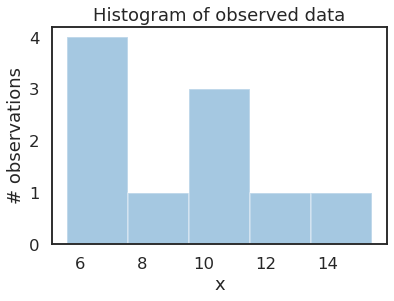

In [69]:
ax = plt.subplot()
sbn.distplot(data, kde=False, ax=ax,bins=5)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Here are the likelihood and posterior analytical pdf's. 

In [10]:
def calc_posterior_analytical(data, x, sigma, mu_0, sigma_0):
    n = len(data)
    # posterior parameter
    mu_post = ( mu_0/(sigma_0**2) + data.sum()/(sigma**2) )*(1. / sigma_0**2 + n / sigma**2)**(-1)
    sigma_post = np.sqrt((1. / sigma_0**2 + n / sigma**2)**(-1))
    # probabilities
    posterior = norm(mu_post,sigma_post).pdf(x)
    prior = norm(mu_0,sigma_0).pdf(x)
    return posterior,prior,mu_post,sigma_post 

The function `plot_proposal` is **rather long** and cumbersome, but it is nice for generating plots that show how MH works iteration by iteration.   

In [217]:
# allows us to plot what is happening inside the sampler iteration by iteration
def plot_proposal(chain_dict):
    
    # extract info from sampled chain
    sample_id = chain_dict['sample_id'] 
    samples = max(sample_id) + 1
    
    # chain parameter values, likelihoods, posteriors, and priors
    current_ = chain_dict['current']
    proposal_ = chain_dict['proposal']
    
    # whether proposal is accepted
    accept = chain_dict['accept']
    
    # extract hyperparameters on priors
    mu_prior_mu = chain_dict['priors'][0] 
    mu_prior_sd = chain_dict['priors'][1]
    
    plt.figure(figsize=(16, 16))
    
    x = np.linspace(3, 15, 1000)
    
    trace = [current_[0, 0]]
    
    subplot_counter = 1
    
    for i in sample_id:
        
        current = current_[i, 0]
        prior_current = current_[i, 1]
        like_current = current_[i, 2]
        post_current = current_[i, 3]
        
        proposal = proposal_[i, 0]
        prior_proposal = proposal_[i, 1]
        like_proposal = proposal_[i, 2]
        post_proposal = proposal_[i, 3]
    
        color = 'g' if accept[i] else 'r'
        
        mu_current = current_[i, 0]
        mu_proposal = proposal_[i, 0]
                
        # Plot prior for this sample
        plt.subplot(samples, 4, subplot_counter)        
        prior_current = current_[i, 1]
        prior_proposal = proposal_[i, 1]
        prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
        
        plt.plot(x, prior, color='k')
        plt.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
        plt.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
        plt.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                     arrowprops=dict(arrowstyle="->", lw=2.))
        plt.ylabel('Sample %s\nProbability Density'%str(i+1), fontsize=12)
        plt.title('current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal),
                 fontsize=11)
        # fill in x labels for last row
        if i == max(sample_id):
            plt.xlabel(r'$\mu$', fontsize=12)
    
        # Plot likelihood for this sample
        plt.subplot(samples, 4, subplot_counter + 1)
        y = np.array([norm(loc=i,scale=sigma).pdf(data).prod() for i in x])
        plt.plot(x, y, color='k')
        plt.plot([mu_current,mu_current],[0,like_current], color='b', marker='o', label='mu_current')
        plt.plot([mu_proposal,mu_proposal],[0,like_proposal], color=color, marker='o', label='mu_proposal')
        plt.annotate("", xy=(mu_proposal, 0.8*1e-7), xytext=(mu_current, 0.8*1e-7),
                     arrowprops=dict(arrowstyle="->", lw=2.))
        plt.title('likelihood(mu=%.2f) = %.2e\nlikelihood(mu=%.2f) = %.2e' % (mu_current, like_current, mu_proposal, like_proposal),
                 fontsize=11)
        # fill in x labels for last row
        if i == max(sample_id):
            plt.xlabel(r'$\mu$', fontsize=12)
        
        # Posterior for this sample
        plt.subplot(samples, 4, subplot_counter + 2)
        posterior_analytical, prior, mu_post, sigma_post  = calc_posterior_analytical(data, x, sigma, mu_prior_mu, mu_prior_sd)
        plt.plot(x, posterior_analytical,color='k')
        posterior_current, prior,mu_post,sigma_post  = calc_posterior_analytical(data, mu_current, sigma, mu_prior_mu, mu_prior_sd)
        posterior_proposal,prior,mu_post,sigma_post  = calc_posterior_analytical(data, mu_proposal, sigma, mu_prior_mu, mu_prior_sd)
        plt.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
        plt.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
        plt.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
        plt.title('posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, post_current, mu_proposal, post_proposal),
                 fontsize=11)
        # fill in x labels for last row
        if i == max(sample_id):
            plt.xlabel(r'$\mu$', fontsize=12)
        
        # Trace with this additional sample
        if accept[i]:
            trace.extend([mu_proposal])
        else:
            trace.extend([mu_current])
        
        plt.subplot(samples, 4, subplot_counter + 3)
        plt.plot(trace,color='k')
        plt.ylabel(r'$\mu$')
        plt.title('Trace', fontsize=12)
        
        # fill in x labels for last row
        if i == max(sample_id):
            plt.xlabel('Sample', fontsize=12)
        
        subplot_counter += 4
    
    sbn.despine(offset=2.)
    plt.tight_layout()
    plt.show()

The function `sampler` below is a simple Metropolis-Hastings sampler for 1 unknown parameter.  It can spawn the plotter function to plot **each** iteration of the sampler, so beware if setting `plot=True` with large samples.

In [221]:
# a fairly basic mh mcmc random walk sampler:
def sampler(data, samples=4, mu_init=8., sigma= 1, proposal_width=3., 
            mu_prior_mu=0., mu_prior_sd=1., plot_data=False):
    store_vals = np.zeros((samples, 4, 2)) # first page is current, 2nd proposal
    store_accept = np.zeros(samples)
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()
        
        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, sigma).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, sigma).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        c = np.min((1,p_proposal / p_current))
        
        accept = np.random.rand() <= c
        
        # store all values for current and acceptance
        store_vals[i, :, 0] = np.c_[mu_current, prior_current, likelihood_current, p_current]
        store_vals[i, :, 1] = np.c_[mu_proposal, prior_proposal, likelihood_proposal, p_proposal]
        store_accept[i] = accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    if plot_data:
        return np.array(posterior), {'current': store_vals[:, :, 0], 'proposal': store_vals[:, :, 1], 
                                     'accept': store_accept,'sample_id': [i for i in range(samples)], 
                                     'priors': [mu_prior_mu, mu_prior_sd]}
    else:
        return np.array(posterior)

In [222]:
# the function needs to be called in order to produce something we can work with:
# here, we are going to only take 6 samples and plot what is happening.
# Note: green proposals are accepted, and red proposals are not accepted
chain_for_pic, plot_data = sampler(data,samples=6,mu_init=8., sigma=sigma, proposal_width=1.,
                        mu_prior_mu=mu_prior, mu_prior_sd=sigma_prior, plot_data=True)

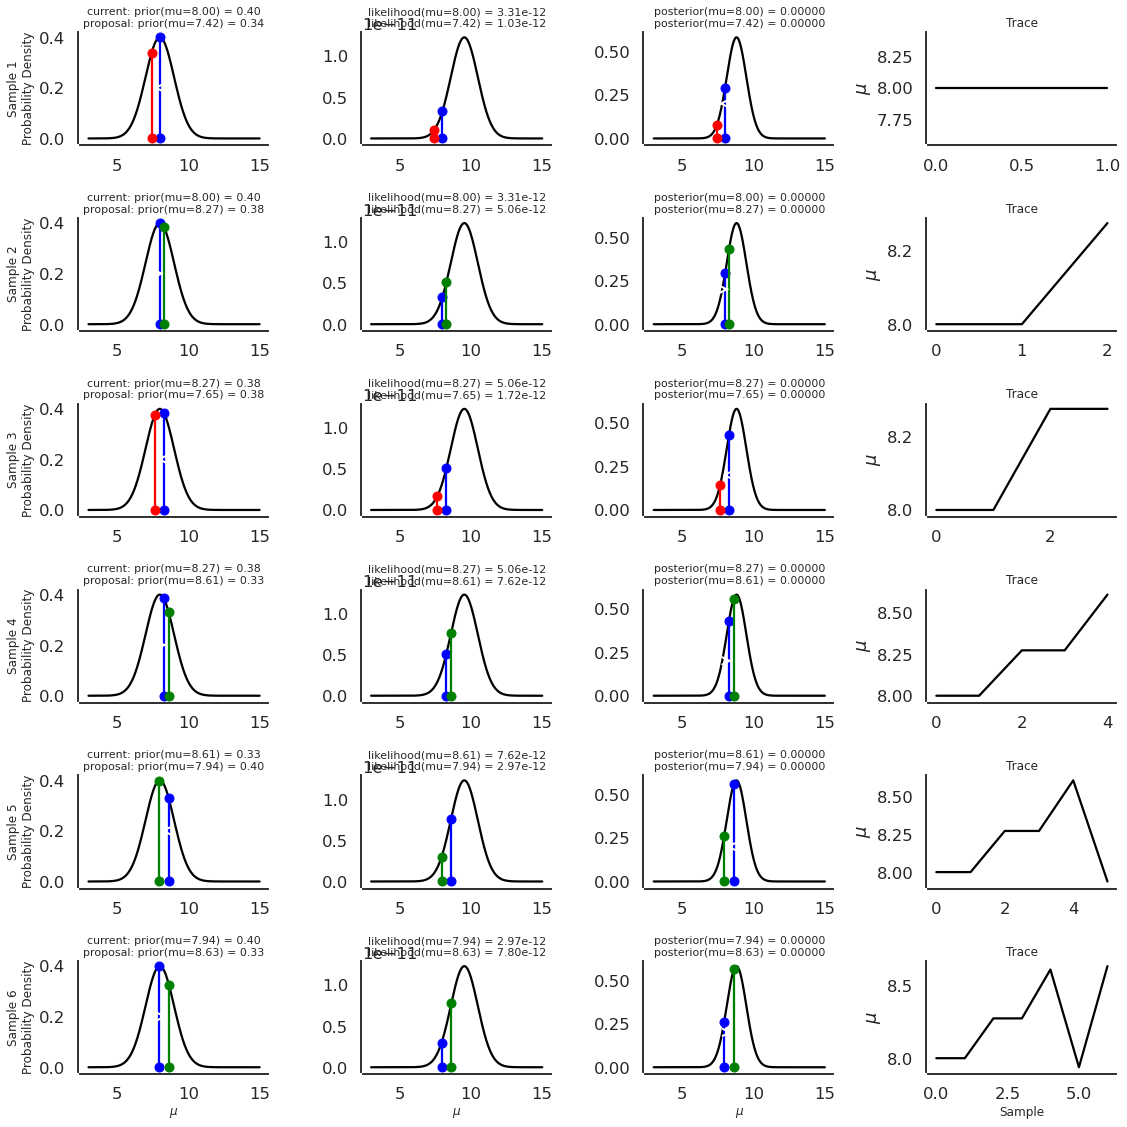

In [223]:
plot_proposal(plot_data)

In [224]:
# take lots of samples and turn harvesting of plotting data off.
chain = sampler(data,samples=5000,mu_init=0,sigma=3,proposal_width=3,plot_data=False,
                mu_prior_mu=mu_prior,mu_prior_sd=sigma_prior)

The following plot, called a traceplot, is probably the **first** thing you should look at after the markov chain has been constructed:

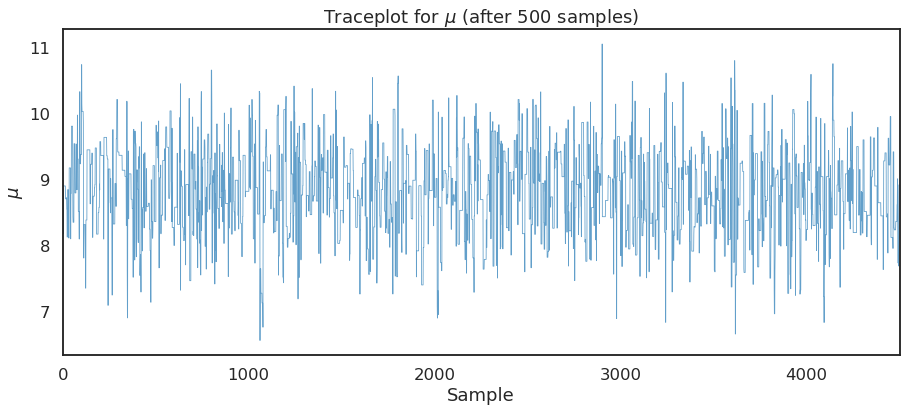

In [225]:
plt.figure(figsize=(15,6))
plt.plot(chain[500:],lw=.8,alpha=.7)
plt.xlim(0,chain.shape[0]-500)
plt.xlabel('Sample')
plt.ylabel('$\\mu$')
plt.title('Traceplot for $\\mu$ (after 500 samples)') 
plt.show()

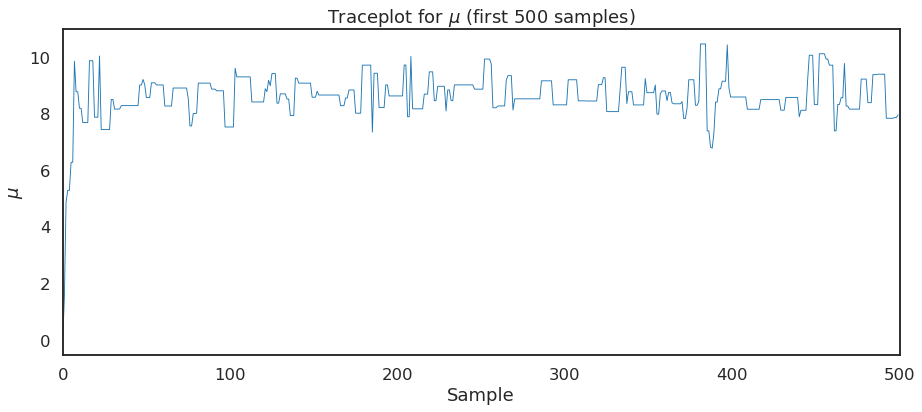

In [226]:
plt.figure(figsize=(15,6))
plt.plot(chain[:500],lw=.9)
plt.xlim(0,500)
plt.xlabel('Sample')
plt.ylabel('$\\mu$')
plt.title('Traceplot for $\\mu$ (first 500 samples)') 
plt.show()

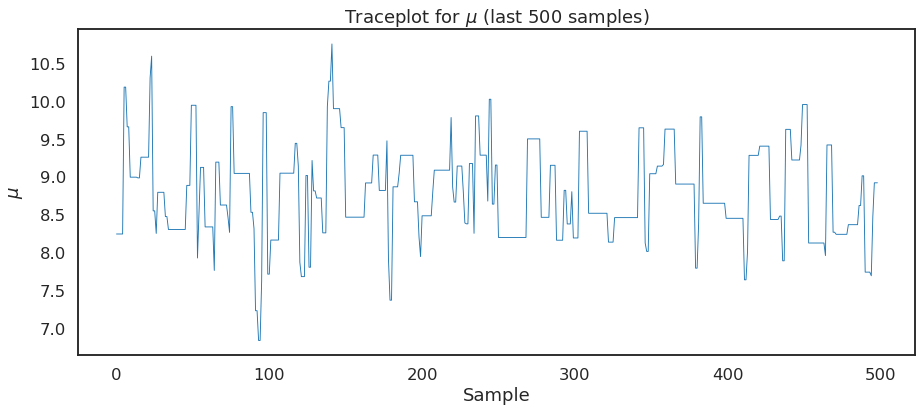

In [227]:
plt.figure(figsize=(15,6))
plt.plot(chain[chain.shape[0]-500:-1],lw=.9)
plt.xlabel('Sample')
plt.ylabel('$\\mu$')
plt.title('Traceplot for $\\mu$ (last 500 samples)') 
plt.show();

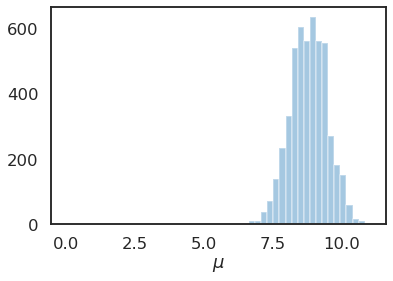

In [228]:
sbn.distplot(chain, kde=False, bins=50)
plt.xlabel('$\\mu$')
plt.show()

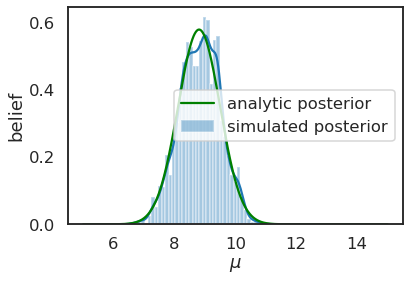

In [229]:
ax = plt.subplot()

sbn.distplot(chain[500:], ax=ax, label='simulated posterior')
x = np.linspace(5, 15, 500)
post,prior,mu_post,sigma_post = calc_posterior_analytical(data, x, sigma, mu_prior, sigma_prior)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='$\\mu$', ylabel='belief');
ax.legend();

## Practical issue \#1: Proposal width

In all the analysis above, we assumed a proposal width of 3.  What is the proposal width and why have we set it at 3?  Recall that the proposal width $\omega$ is 

$$
\theta^P_{t+1} = \theta_t + N(0,\omega)
$$

So larger values of the proposal width means that we are jumping further in the parameter space in our exploration of the posterior.  Smaller values means we jump less.  

> Question: Will smaller values of the proposal width lead to _lower_ or _higher_ acceptance rates?

In [231]:
posterior_small = sampler(data,samples=5000,mu_init=6,sigma=3,proposal_width=.05,
                         mu_prior_mu=mu_prior,mu_prior_sd=sigma_prior, plot_data=False)
posterior_large = sampler(data,samples=5000,mu_init=6,sigma=3,proposal_width=9,
                         mu_prior_mu=mu_prior,mu_prior_sd=sigma_prior, plot_data=False)
posterior_medium = sampler(data,samples=5000,mu_init=6,sigma=3,proposal_width=3,
                         mu_prior_mu=mu_prior,mu_prior_sd=sigma_prior, plot_data=False)

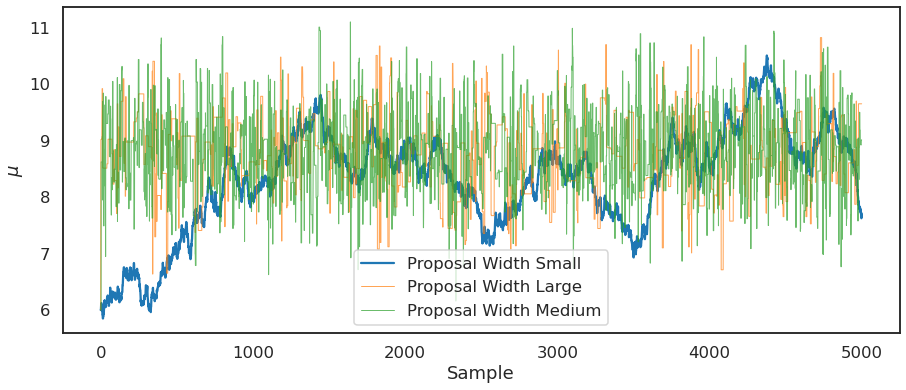

In [232]:
plt.figure(figsize=(15,6))
plt.plot(posterior_small[0:],label='Proposal Width Small');
plt.plot(posterior_large[0:],label='Proposal Width Large',lw=1,alpha=.7)
plt.plot(posterior_medium[0:], label='Proposal Width Medium', lw=1, alpha=.7)
plt.xlabel('Sample')
plt.ylabel('$\\mu$')
plt.legend()
plt.show()

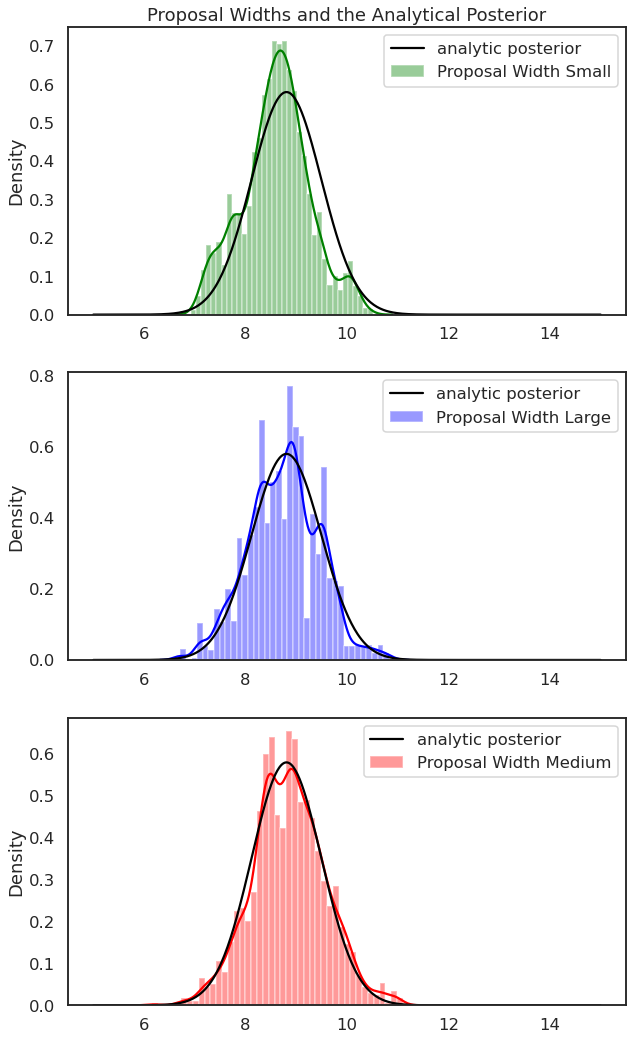

In [233]:
plt.figure(figsize=(10,18))
plt.subplot(3,1,1)
plt.title('Proposal Widths and the Analytical Posterior')
sbn.distplot(posterior_small[1000:], label='Proposal Width Small',color='g')
plt.plot(x, post, 'k', label='analytic posterior')
plt.legend()

plt.subplot(3,1,2)
sbn.distplot(posterior_large[1000:], label='Proposal Width Large',color='b')
plt.plot(x, post, 'k', label='analytic posterior')
plt.legend()

plt.subplot(3,1,3)
sbn.distplot(posterior_medium[1000:], label='Proposal Width Medium',color='r')
plt.plot(x, post, 'k', label='analytic posterior')
plt.legend()
plt.show()

## Practical Issue \#2: Burn-in and Convergence

How do we know when our chain has converged and is oscillating around the posterior in a way that is proportional to the posterior probability?  We will turn back to this question later in the course, but to understand the problem, consider this plot:

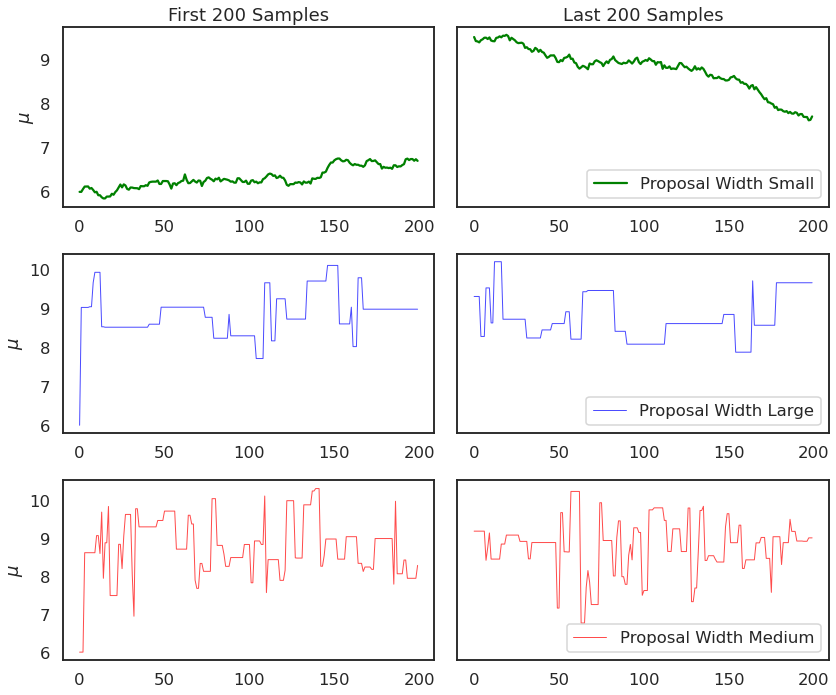

In [234]:
plt.figure(figsize=(12,10))
ax1 = plt.subplot(321)
ax1.set_title('First 200 Samples')
line1, = ax1.plot(posterior_small[:200],label='Proposal Width Small',c='g')
ax1.set_ylabel('$\\mu$')

ax2 = plt.subplot(322,sharey=ax1)
ax2.set_title('Last 200 Samples')
ax2.plot(posterior_small[-200:],label='Proposal Width Small',c='g')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc = 'lower right')

ax3 = plt.subplot(3,2,3)
line2, = ax3.plot(posterior_large[:200],label='Proposal Width Large',lw=1,alpha=.7,c='b')
ax3.set_ylabel('$\\mu$')

ax4 = plt.subplot(324,sharey=ax3)
ax4.plot(posterior_large[-200:],label='Proposal Width Large',lw=1,alpha=.7,c='b')
ax4.get_yaxis().set_visible(False)
ax4.legend(loc = 'lower right')

ax5 = plt.subplot(3,2,5)
line3, = ax5.plot(posterior_medium[:200], label='Proposal Width Medium', lw=1, alpha=.7,c='r')
ax5.set_ylabel('$\\mu$')

ax6 = plt.subplot(326,sharey=ax5)
ax6.plot(posterior_medium[-200:], label='Proposal Width Medium', lw=1, alpha=.7,c='r')
ax6.get_yaxis().set_visible(False)
ax6.legend(loc = 'lower right')

plt.tight_layout()
plt.show()

## Practical issue \#3: autocorrelation

One troubling aspect of our MH Sampler is that we often reject proposals, or the chain moves very slowly in the parameter space.  Consequently, a value of the chain may be correlated with previous values of the chain.  To quantify this, the lag k autocorrelation $\rho_k$ is the correlation between every draw and its kth lag:

$$
\rho_k = \frac{\sum_{i=1}^{N-k}(x_i - \bar{x})(x_{i+k}-\bar{x})}{\sum_{i=1}^N (x_i - (\bar{x}))^2}
$$

Note, we might also use this as a convergence diagnostic.

In [241]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

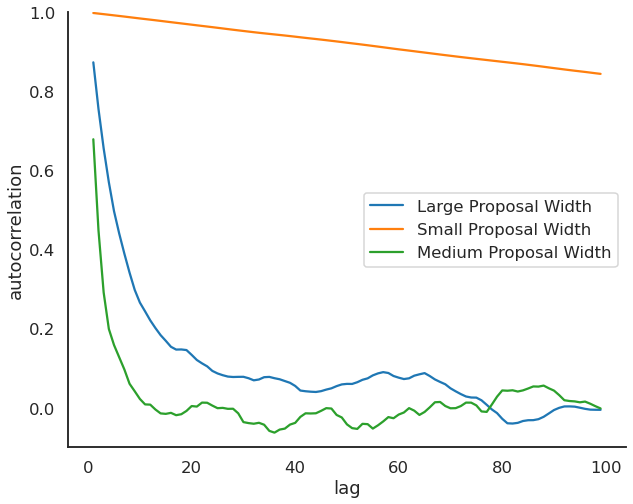

In [248]:
lags=np.arange(1,100)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(lags, acf(posterior_large, 100)[1:], label='Large Proposal Width')
ax.plot(lags, acf(posterior_small, 100)[1:], label='Small Proposal Width')
ax.plot(lags, acf(posterior_medium, 100)[1:], label='Medium Proposal Width')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))
sbn.despine()
plt.show()

## For now, a quick rule of thumb

Adaptively search (while constructing the MH MCMC) for proposal width until accept approximately 20-40% of samples (it depends on the type of sampler you are using). This adaptive approach helps with all of these issues.  The paper [here](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.aoap/1034625254) suggests an acceptance rate of .234 for random walk MH.

In [22]:
changes_small = np.sum((posterior_small[1:] != posterior_small[:-1]))
changes_large = np.sum((posterior_large[1:] != posterior_large[:-1]))
changes_medium = np.sum((posterior_medium[1:] != posterior_medium[:-1]))

length = posterior_small.shape[0]

print("Acceptance rate for small proposal width: ", (changes_small)/(length-1))
print("Acceptance rate for large proposal width: ", (changes_large)/(length-1))
print("Acceptance rate for medium proposal width: ", (changes_medium)/(length-1))

Acceptance rate for small proposal width:  0.9666
Acceptance rate for large proposal width:  0.1046
Acceptance rate for medium proposal width:  0.2744
